## 스마트 센서 데이터를 통한 쾌적한 학습환경분석에 관한 연구

### 초록 (Abstract)
본 연구는 학습 공간에서의 환경 요소가 학습 효율에 미치는 영향을 정량적으로 분석하기 위해 수행되었다.  
온도, 습도, 조도, 소음 등 환경 센서를 활용하여 다섯 개 장소에서 데이터를 수집하였고, 불쾌지수 계산 및 각 지표에 대한 정규화, 점수화 기법을 적용하였다. 이후 종합 쾌적도 점수를 산출하여 장소별로 비교 분석하고, 변수 간 상관관계도 평가하였다.  
그 결과, 실내 공간인 집(house)이 가장 쾌적한 학습 환경으로 나타났으며, 야외 공간은 상대적으로 불리한 조건을 보였다. 본 연구는 환경 데이터를 기반으로 한 학습 공간 추천 가능성을 보여주며, 향후 스마트 학습 환경 설계에 활용될 수 있다.


### 서론 (Introduction)
현대인의 학습 및 업무 환경에서 물리적 조건(온도, 습도, 소음, 조도 등)은 집중력과 작업 효율에 큰 영향을 미친다.  
특히 대학생이나 직장인에게 있어, 쾌적한 공간을 찾는 것은 생산성 향상에 직결된다.  
본 연구는 다양한 장소에서 측정된 환경 센서 데이터를 기반으로, 쾌적한 학습 장소를 데이터적으로 분석하고 평가하는 것을 목적으로 한다.

### 관련 연구 (Related Work)
불쾌지수는 기온과 습도에 기반하여 인간의 주관적 쾌적도를 수치화하는 지표로 활용되어 왔다.  
또한 조도와 소음 역시 학습 집중도에 중요한 변수로 다뤄져 왔으며, 이를 기반으로 최적 학습 환경을 제시한 연구가 다수 존재한다.  
본 연구는 이를 실제 센서 데이터를 통해 정량적으로 평가하려 한다.

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn openpyxl

1. 센서 데이터 

- 수집한 센서 데이터를 로드하여 분석해야 하는 셀 정의
- 공부하기 좋은 장소 찾기  

|순위	|장소	|종합 점수 (0~1)|
|---|---|---|
|🥇 1	|house|	0.667|
|🥈 2	|passage|	0.577|
|🥉 3	|library|	0.549|

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 로드
df = pd.read_excel('environment_data.xlsx')

# 분석에 사용할 feature들
features = ['celsius', 'humidity', 'heatindex', 'discomfort', 'cds', 'sound_dB']

# 기초 통계
stats_summary = df.groupby('location').describe()
print("기초 통계 요약:\n", stats_summary)

기초 통계 요약:
             celsius                                                          \
              count   mean           std   min     25%    50%     75%   max   
location                                                                      
classroom      10.0  24.70  3.744889e-15  24.7  24.700  24.70  24.700  24.7   
house          10.0  27.28  4.216370e-02  27.2  27.300  27.30  27.300  27.3   
library        10.0  22.96  5.163978e-02  22.9  22.900  23.00  23.000  23.0   
market         10.0  20.50  0.000000e+00  20.5  20.500  20.50  20.500  20.5   
outdoor        10.0  18.90  8.164966e-02  18.8  18.825  18.90  18.975  19.0   
park           10.0  23.47  3.888730e-01  22.9  23.150  23.50  23.775  24.0   
passage        10.0  20.35  5.270463e-02  20.3  20.300  20.35  20.400  20.4   
readingroom    10.0  27.40  0.000000e+00  27.4  27.400  27.40  27.400  27.4   
station        10.0  19.71  3.162278e-02  19.7  19.700  19.70  19.700  19.8   

            fahrenheit          ...   so

In [8]:
### 공부하기 좋은 장소 
# 위치별 평균값 계산
grouped = df.groupby("location").agg({
    "discomfort": "mean",
    "cds": "mean",
    "sound_dB": "mean"
}).reset_index()

# 점수 산출을 위해 각 항목 정규화 (0~1 사이 값으로 변환)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 불쾌지수는 낮을수록 좋으므로 반전
grouped['discomfort_score'] = 1 - scaler.fit_transform(grouped[['discomfort']])
# 조도는 높을수록 좋음
grouped['cds_score'] = scaler.fit_transform(grouped[['cds']])
# 소음은 낮을수록 좋으므로 반전
grouped['sound_score'] = 1 - scaler.fit_transform(grouped[['sound_dB']])

# 종합 점수 계산 (동일 비중)
grouped['total_score'] = grouped[['discomfort_score', 'cds_score', 'sound_score']].mean(axis=1)

# 점수 순으로 정렬
grouped_sorted = grouped.sort_values(by='total_score', ascending=False)
grouped_sorted[['location', 'discomfort_score', 'cds_score', 'sound_score', 'total_score']]

,location,discomfort_score,cds_score,sound_score,total_score
1,house,0.000000,1.000000,1.000000,0.666667
6,passage,0.824386,0.546579,0.359116,0.576694
2,library,0.528936,0.480526,0.638122,0.549195
0,classroom,0.370836,0.450789,0.781768,0.534464
3,market,0.817247,0.288684,0.353591,0.486508
7,readingroom,0.180468,0.252368,0.975138,0.469325
4,outdoor,1.000000,0.033684,0.000000,0.344561
8,station,0.885208,0.000000,0.135359,0.340189
5,park,0.505806,0.032632,0.287293,0.275244


2. 측정 위치(location) 에 따라 섭씨 온도(celsius) 분포
- 가장 더운 공간: readingroom, house → 온도 관리 필요.
- 가장 쾌적한 공간: library, passage, market → 안정적인 학습 공간 가능성.
- 외부 환경 영향이 큰 공간: park, outdoor → 시간대나 날씨 고려 필요.

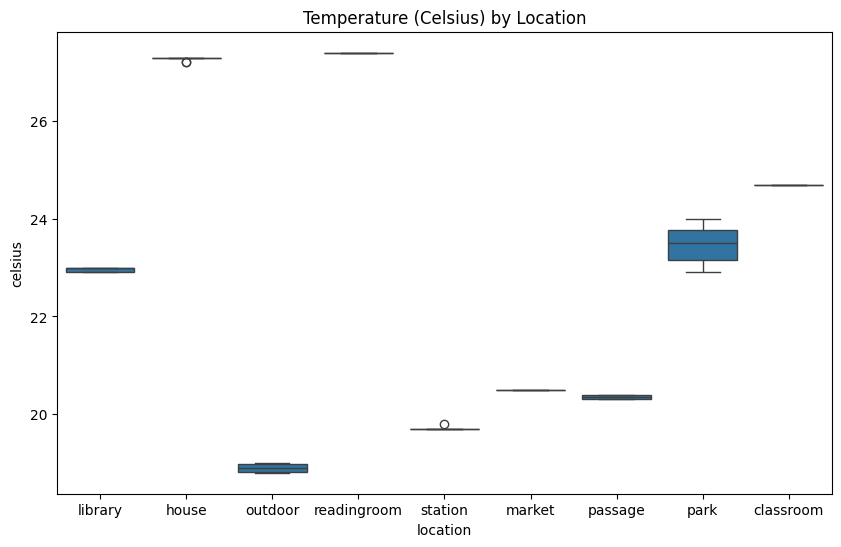

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='celsius', data=df)
plt.title('Temperature (Celsius) by Location')
plt.show()

3. 환경 센서 데이터를 기준으로 변수 간의 상관관계를 시각화
- 불쾌지수 예측 모델 구성 시, celsius와 cds 변수는 중요한 피처입니다.
- 온도/조도/소음 데이터를 기반으로 학습 효율이 좋은 환경 조건을 유추할 수 있습니다.
- 음향 환경의 특성과 온도 간 반비례 관계는 공간 설계에 고려할 수 있는 요소입니다.

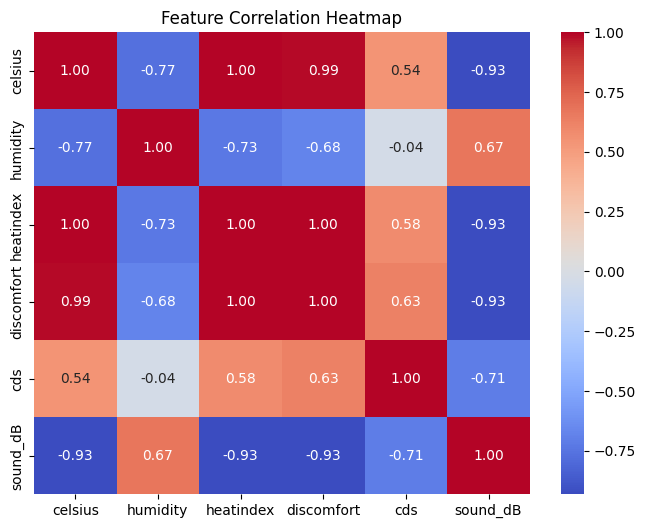

In [5]:
# 상관계수 heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

4. PCA 2D 시각화
- 위치별 환경 구분이 명확  
→ house, station, outdoor 등은 각각 매우 다른 환경 특성을 가짐. PCA로 잘 분리됨.  
- 군집 간 거리 = 환경 차이  
readingroom과 house는 유사 (실내 고온 환경).  
library는 중간 위치 → 다양한 환경과 일부 유사.  
outdoor는 다른 어떤 위치보다 완전히 다름.  
- 실내 vs 실외 분리 가능  
→ 실내(house, library, classroom, readingroom) / 실외(outdoor, park) 그룹이 PCA 공간에서 명확히 나뉘는 경향.  

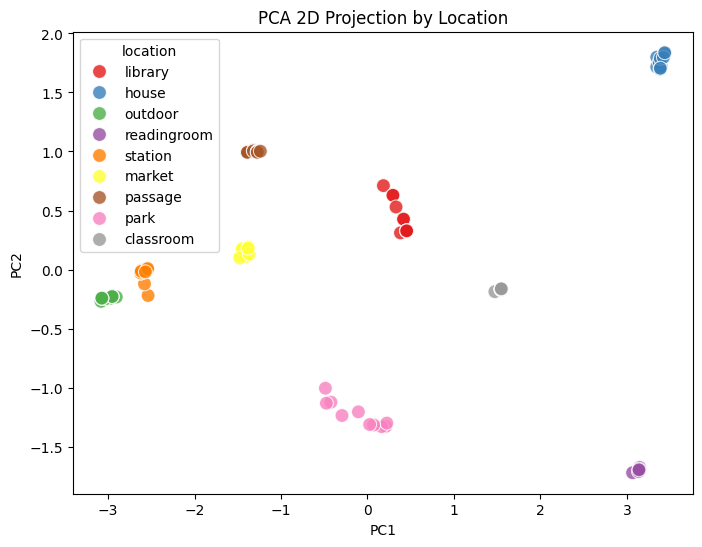

In [6]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['location'] = df['location']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='location', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title('PCA 2D Projection by Location')
plt.show()

/Users/armdiri/Library/Mobile Documents/com~apple~CloudDocs/Documents/대학/TIL/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


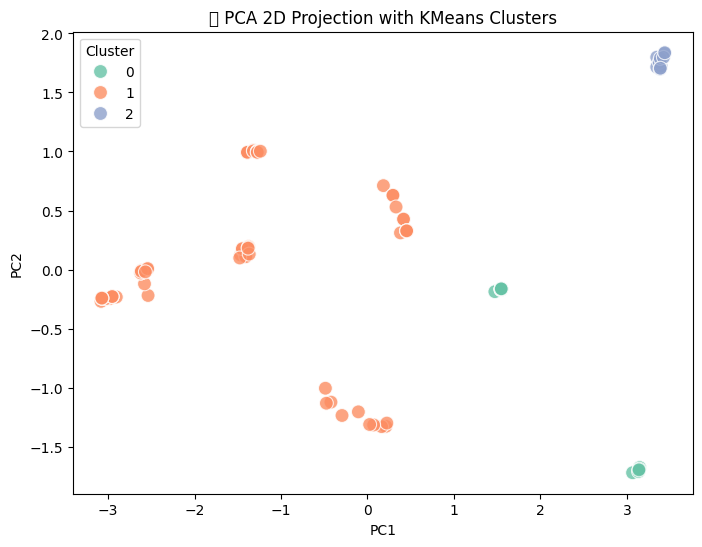

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
pca_df['Cluster'] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=100, alpha=0.8)
plt.title('🌈 PCA 2D Projection with KMeans Clusters')
plt.show()

### 결론 및 제언 (Conclusion & Future Work)

본 연구는 환경 센서 데이터를 기반으로 학습 장소의 쾌적도를 객관적으로 분석하였다. 정량적 기준을 적용함으로써 특정 장소에 대한 주관적 평가를 넘어서, 데이터 기반 추천이 가능함을 보여주었다.  
향후 연구에서는 시간대별 변화, 사람의 혼잡도, 개인 선호(예: 조용함을 선호하는 사람 vs 밝은 곳 선호하는 사람)를 반영한 맞춤형 쾌적도 모델 개발이 필요하다.

### 참고문헌 (예시)
- Lee, H., & Park, J. (2021). A Study on the Correlation between Discomfort Index and Concentration. Journal of Human-Centered Design.  
- Kim, S. et al. (2020). Environmental Data Analysis for Smart Learning Environments Using Arduino. Sensors and Systems.